In [1]:
from __future__ import print_function
from os import listdir
from os.path import isfile, join
import geopandas
import matplotlib as mat
import matplotlib.pyplot as plt
import os
import math
import numpy as np
import scipy.misc as spmisc
from PIL import Image
from shapely.geometry import Point, Polygon
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider
import pickle

In [2]:
mypath = "./srtm/version2_1/SRTM3/Eurasia"

In [3]:
files = [f.split(".")[0] for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
coords = []
europeCoordsWithFiles = []
for f in files:
    if(len(f) == 0 or f[0] == "i"):
        continue
    n = int(f[1:3])
    e=int(f[4:7])
    coords.append((n,e))
    europeCoordsWithFiles.append((f, (n,e)))

In [5]:
earth = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [6]:
poland = earth.query('name == "Poland"')["geometry"][113]

In [7]:
krakówCoords = [('N50E019', (50, 19))] #50°03′41″N 19°56′14″E

In [8]:
polandCoordsWithFiles = list(filter(lambda x: any([Point(x[1][1]+i,x[1][0]+j).within(poland) for i in range(2) for j in range(2)]), europeCoordsWithFiles))

In [9]:
polandSquareCoords=[(y,x) for x in range(14,25) for y in range(49, 55)] # -N 55 -S 49 -W 14 -E 25

In [10]:
polandSquareCoordsWithFiles = list(filter(lambda x: x[1] in polandSquareCoords,europeCoordsWithFiles))

In [11]:
coordsWithFiles = polandSquareCoordsWithFiles

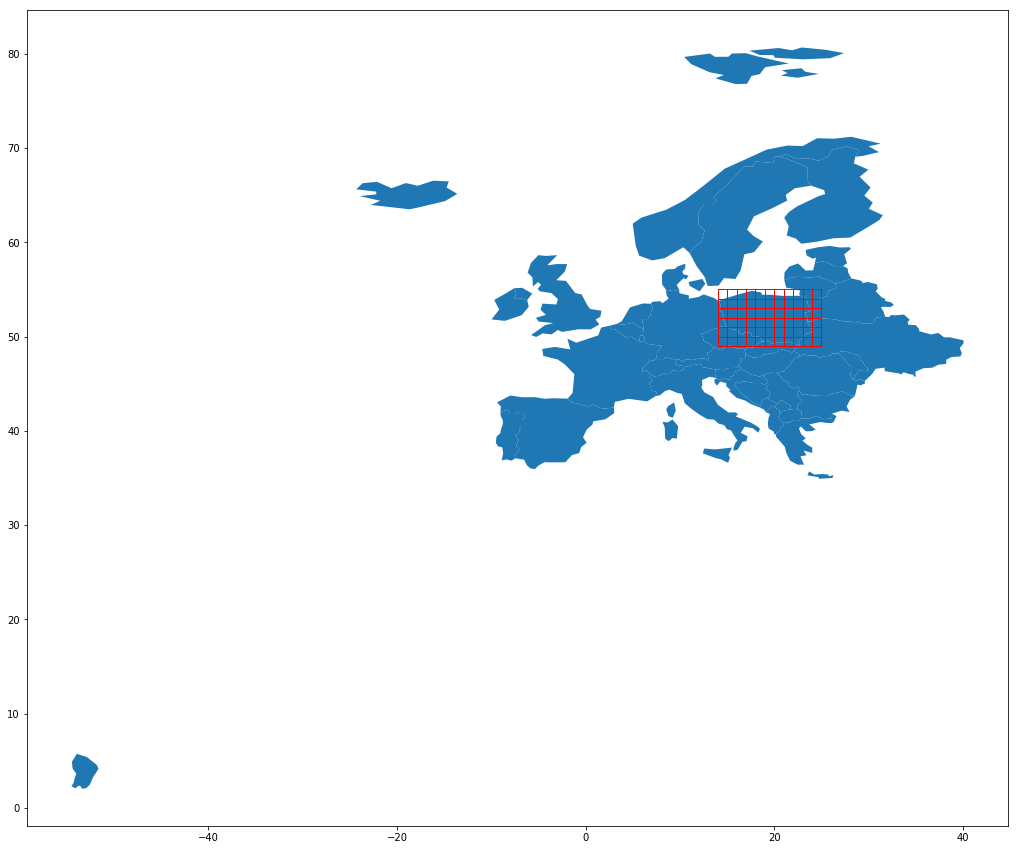

In [12]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(30)
ax = fig.add_subplot(111)
earth.query('continent == "Europe"').query('name != "Russia"').plot(ax=ax);
for c in coordsWithFiles:
    ax.add_patch(
    mat.patches.Rectangle((c[1][1], c[1][0]), 1,1,color="red",lw=1,fill=False))


In [13]:
boundaries = {"W":min(map(lambda x:x[1][1], coordsWithFiles)),"E":max(map(lambda x:x[1][1], coordsWithFiles)),"N":max(map(lambda x:x[1][0], coordsWithFiles)),"S":min(map(lambda x:x[1][0], coordsWithFiles))}

In [14]:
boundaries

{'W': 14, 'E': 24, 'N': 54, 'S': 49}

In [15]:
fn = './srtm/version2_1/SRTM3/Eurasia/N50E057.hgt'

siz = os.path.getsize(fn)
dim = int(math.sqrt(siz/2))

assert dim*dim*2 == siz, 'Invalid file size'
dim
smallDim = dim

In [16]:
mapArr = np.zeros(((boundaries["N"] - boundaries["S"]+1)*smallDim,((boundaries["E"] - boundaries["W"]+1)*smallDim)))
mapArr.shape

(7206, 13211)

In [17]:
for file,coords in coordsWithFiles:
    try:
        fn='./srtm/version2_1/SRTM3/Eurasia/'+file+'.hgt'
        data = np.fromfile(fn, np.dtype('>i2'), dim*dim).reshape((dim, dim))
        coordsMoved = [coords[1]-boundaries["W"], coords[0]-boundaries["S"]]
    #NS, WE
        resData = np.flip(np.rot90(np.array(Image.fromarray(data).resize((smallDim, smallDim), resample=Image.NEAREST)),2),axis=1)
        pos = [coordsMoved[1]*smallDim, coordsMoved[0]*smallDim]
        #print((coordsMoved,pos, resData.shape, mapArr.shape, mapArr[pos[0]:pos[0]+resData.shape[0]].shape))

        mapArr[pos[0]:pos[0]+resData.shape[0],pos[1]:pos[1]+resData.shape[1]] = resData
        
    except Exception as e: print(e)

In [18]:
mapArr = np.flip(np.flip(mapArr),axis=1)

In [19]:
@interact(vmin=FloatSlider(min=0, max=6400, step=2, continuous_update=False), vmax=FloatSlider(min=1, max=6400, step=2, continuous_update=False))
def showChart(vmin, vmax):
    plt.figure(figsize = (20,20))
    plt.imshow(mapArr,vmin=vmin, vmax=vmax,  cmap='gray', interpolation='nearest')
# plt.show()


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='vmin', max=6400.0, step=2.0…

In [20]:
size = 7000
data = np.matrix(Image.fromarray(mapArr).resize((size, size), resample=Image.NEAREST))

In [21]:
data.shape

(7000, 7000)

In [22]:
np.max(data)

2575.0

In [23]:
pickle.dump(data, open("7000_poland_square_matrix.pkl", "wb"))

# saving to a 3d file

In [ ]:
highiestPoint = np.max(mapArr)
highiestPoint

2576.0

In [ ]:
scaledShape = 3000
scaledMapArr = np.clip(np.array(Image.fromarray(mapArr*scaledShape/highiestPoint).resize((scaledShape, scaledShape), resample=Image.NEAREST)),0,scaledShape)

In [ ]:
np.max(scaledMapArr)

2955.7454

# reading files

In [ ]:
fn='./out/yang_0_0_0.data'
dim=300

In [ ]:
genArr = np.fromfile(fn, np.dtype(np.int8), dim*dim*dim)

In [ ]:
data = genArr.reshape((dim, dim,dim)) -48

In [ ]:
terMap = 300 - np.argmax(np.flip(data,axis=0),axis=0)

In [ ]:
terMap = np.where(terMap == 300, 0, terMap)

In [ ]:
plt.imshow(terMap,cmap='terrain') # wygenerowany plik przez skrypt https://github.com/Podsiadlo/terrain/tree/master/Src

In [ ]:
plt.imshow(scaledMapArr,cmap='terrain') # macierz wygenerowana przeze mnie

In [ ]:
outMatrix = np.zeros((scaledShape,scaledShape,scaledShape),dtype="int8")
outMatrix.shape
outMatrix.dtype

In [ ]:
for i in range(0,scaledShape):
    print(i)
    outMatrix[i] = np.where(scaledMapArr >=i, 1, 0)

In [ ]:
outMatrix.dtype

In [ ]:
pickle.dump(outMatrix, open("3000_poland_3d_matrix_of_bits.pkl", "wb"))

In [ ]:
pickle.load(open("3000_poland_3d_matrix_of_bits.pkl","rb")).shape